<a href="https://colab.research.google.com/github/oranzoni/stock-prediction/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ARIMA (AutoRegressive Integrated Moving Average) will be implemented in this part of task.

# Data download and preparation

Data will be downloaded again to have a clear start
An alternative is to use the datasets from Logistic regression and Random forest - but nothing has to be added

In [2]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [3]:
russell_1000 = pd.read_html("https://en.wikipedia.org/wiki/Russell_1000_Index")[3]
russell_1000_tickers = russell_1000.Symbol.tolist()
sp_500_index = '^GSPC'
tickers_merged = russell_1000_tickers + [sp_500_index]
data = yf.download(tickers_merged, start = '2021-01-01', end = '2025-05-30', interval = '1d', auto_adjust= 'False')

[*********************100%***********************]  1003 of 1003 completed
ERROR:yfinance:
7 Failed downloads:
ERROR:yfinance:['UHAL.B', 'BF.B', 'LEN.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-01-01 -> 2025-05-30)')
ERROR:yfinance:['HEI.A']: HTTPError('HTTP Error 500: ')
ERROR:yfinance:['BRK.B', 'CWEN.A', 'BF.A']: YFTzMissingError('possibly delisted; no timezone found')


In [4]:
import holidays
us_holidays = holidays.UnitedStates(years=[2025,2024,2023,2022, 2021])
date_range = pd.date_range(start='2021-01-01', end='2025-05-30', freq='B')
holiday_dates = pd.to_datetime([date for date in us_holidays])
trading_days = date_range[~date_range.isin(holiday_dates)]
filtered_data = data.loc[data.index.isin(trading_days)]

In [5]:
df_filter = filtered_data.stack(level = 1)
df_filter = df_filter.drop('Adj Close', axis = 1)
df_filter.swaplevel().to_csv('ARIMA_filtered_start_data.csv')
ARIMA_df = pd.read_csv('ARIMA_filtered_start_data.csv')

<ipython-input-5-126d976840b0>:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_filter = filtered_data.stack(level = 1)


In [6]:
ARIMA_df

,Ticker,Date,Close,High,Low,Open,Volume
0,A,2021-01-04,115.337708,116.747344,113.850296,115.629360,2.030700e+06
1,AA,2021-01-04,22.343918,23.497153,22.223789,22.699499,5.400000e+06
2,AAL,2021-01-04,15.130000,15.880000,15.030000,15.850000,6.973250e+07
3,AAON,2021-01-04,42.214161,43.936391,41.940171,43.649352,4.200000e+05
4,AAP,2021-01-04,141.919510,143.930963,140.674769,142.424624,8.491000e+05
...,...,...,...,...,...,...,...
1065247,ZION,2025-05-29,47.730000,47.750000,46.889999,47.279999,1.421500e+06
1065248,ZM,2025-05-29,79.940002,80.309998,78.989998,80.230003,1.906400e+06
1065249,ZS,2025-05-29,251.110001,255.160004,248.740005,255.000000,4.228500e+06
1065250,ZTS,2025-05-29,167.139999,167.789993,165.110001,165.919998,2.450400e+06


# Data plotting
Let's see how the data moves and if the data is stationary (it isn't for stocks, but we can pretend :) )

In [7]:
ARIMA_df = ARIMA_df.reset_index()   # “Date” moves from index ➜ column
#AAPL, NVDA, MSFT, META, TSLA, AMZN, ADBE, AXP, AME
df_ticker = ARIMA_df.loc[ARIMA_df['Ticker'].isin(['AAPL', 'NVDA', 'MSFT', 'META', 'TSLA', 'AMZN', 'ADBE', 'AXP', 'AME'])]
df_ticker

,index,Ticker,Date,Close,High,Low,Open,Volume
5,5,AAPL,2021-01-04,126.239700,130.336805,123.654619,130.249014,143301900.0
14,14,ADBE,2021-01-04,485.339996,500.790009,476.279999,500.299988,3612900.0
47,47,AME,2021-01-04,115.152313,118.994619,114.500583,117.798152,1154500.0
55,55,AMZN,2021-01-04,159.331497,163.600006,157.201004,163.500000,88228000.0
87,87,AXP,2021-01-04,111.530678,115.083334,110.406298,114.610907,3472100.0
...,...,...,...,...,...,...,...,...
1064348,1064348,AXP,2025-05-29,295.380005,296.609985,292.799988,296.260010,2362200.0
1064832,1064832,META,2025-05-29,645.049988,653.320007,639.500000,651.650024,8883400.0
1064859,1064859,MSFT,2025-05-29,458.679993,461.720001,455.309998,461.549988,13974800.0
1064902,1064902,NVDA,2025-05-29,139.190002,143.490005,137.910004,142.250000,369241900.0


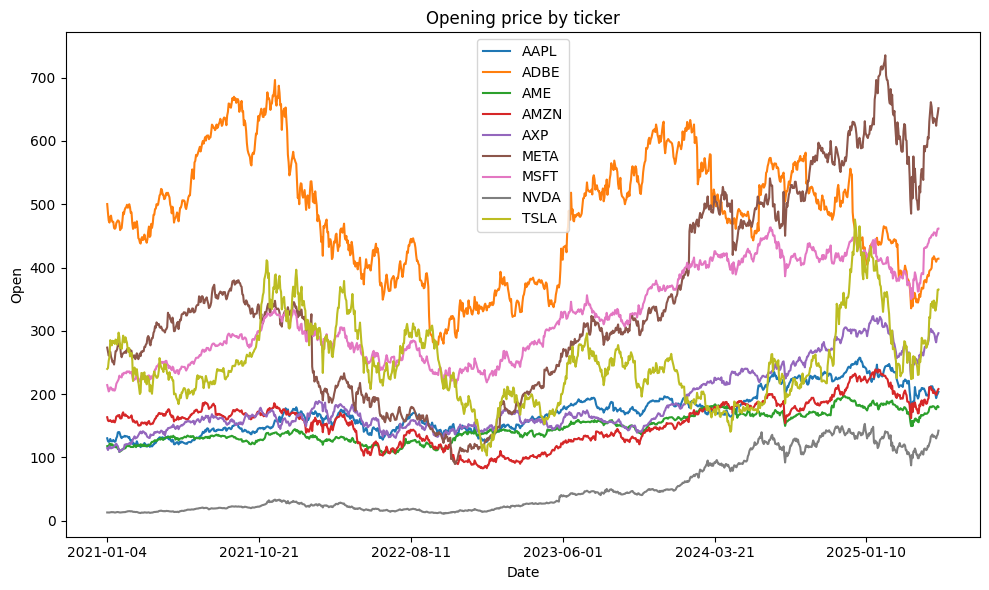

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

for ticker, grp in df_ticker.groupby('Ticker'):
    grp.plot(x='Date', y='Open', ax=ax, label=ticker,linewidth=1.5)

ax.set_title('Opening price by ticker')
ax.set_xlabel('Date')
ax.set_ylabel('Open')
plt.tight_layout()
plt.show()

As it can be seen for the tickers listed, their opening price is non-stationary. If we assume that open-to-open returns are calculated based on opening prices of stocks, we can clearly see that the open-to-open return will also be non-stationary. Therefore, the logic is to apply differencing to get data that is nearly stationary.

# Data differencing and preparation for the model

In [9]:
import numpy as np
ARIMA_df["Log(Open)"] = np.log(ARIMA_df["Open"])
df_ticker["Log(Open)"] = np.log(df_ticker["Open"])

<ipython-input-9-bb6d8caf61ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticker["Log(Open)"] = np.log(df_ticker["Open"])


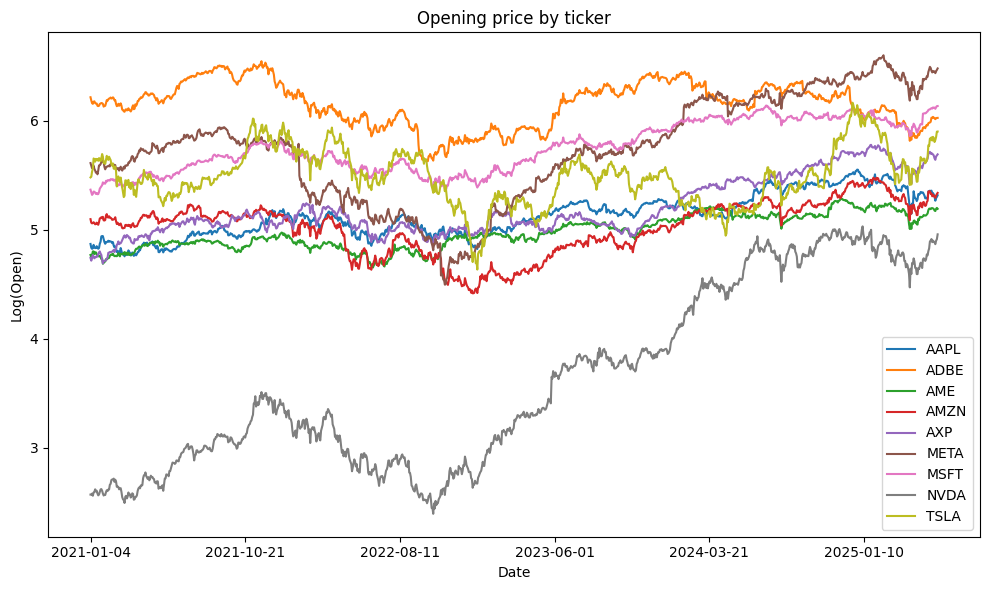

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

for ticker, grp in df_ticker.groupby('Ticker'):
    grp.plot(x='Date', y='Log(Open)', ax=ax, label=ticker,linewidth=1.5)

ax.set_title('Opening price by ticker')
ax.set_xlabel('Date')
ax.set_ylabel('Log(Open)')
plt.tight_layout()
plt.show()

By doing the log of the opening value, the variance is a bit smaller compared to the original one

The next steps will be performed on the smaller dataset of the picked tickers and then moved back to the whole dataset so that the plots are logical and everything what is done can be seen

# Division into training and test datasets

Glavni komentar prije pravljenja datasetova : Zbog prirode ovog modela, a i prirode podataka, napravit će se modifikacija i trenirat će se model za samo jedan ticker. Inherentno ARIMA pravi predikcije nad jednim time series tipom podataka, ali POSTOJI varijanta gdje se može posmatrati tzv. multi time series model. Takav model je ideja za poboljšanje, a ovo u nastavku koristi kao pokazni primjer kako radi statistički bazirani model nad podacima koji čiji razvoj i kretanje zavisi od multiplog broja ograničenja i uslova.

In [13]:
df_ticker
df_ticker.columns = df_ticker.columns.str.strip()
apple = df_ticker[df_ticker["Ticker"] == "AAPL"]

In [22]:
apple

,index,Ticker,Date,Close,High,Low,Open,Volume,Log(Open)
5,5,AAPL,2021-01-04,126.239700,130.336805,123.654619,130.249014,143301900.0,4.869448
939,939,AAPL,2021-01-05,127.800484,128.512611,125.283687,125.732425,97664900.0,4.834156
1873,1873,AAPL,2021-01-06,123.498520,127.839507,123.283908,124.591085,155088000.0,4.825037
2807,2807,AAPL,2021-01-07,127.712692,128.405305,124.727659,125.215410,109578200.0,4.830036
3741,3741,AAPL,2021-01-08,128.815018,129.380811,127.039597,129.185698,105158200.0,4.861251
...,...,...,...,...,...,...,...,...,...
1060277,1060277,AAPL,2025-05-22,201.360001,202.750000,199.699997,200.710007,46742400.0,5.301861
1061273,1061273,AAPL,2025-05-23,195.270004,197.699997,193.460007,193.669998,78432900.0,5.266156
1062269,1062269,AAPL,2025-05-27,200.210007,200.740005,197.429993,198.300003,56288500.0,5.289781
1063265,1063265,AAPL,2025-05-28,200.419998,202.729996,199.899994,200.589996,45339700.0,5.301263


In [23]:
df_train = apple[:-300].copy()
df_test = apple[-300:].copy()

# Sanity check for stationarity for training and test datasets

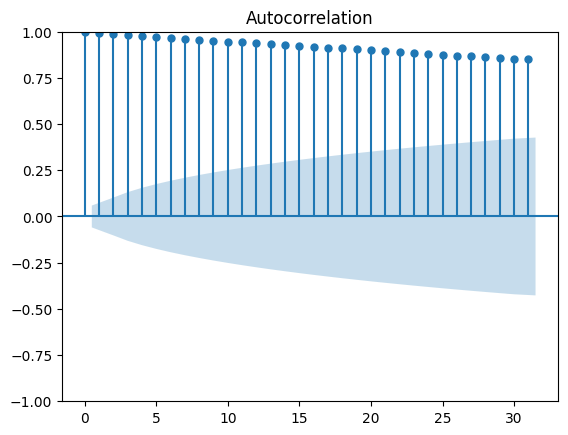

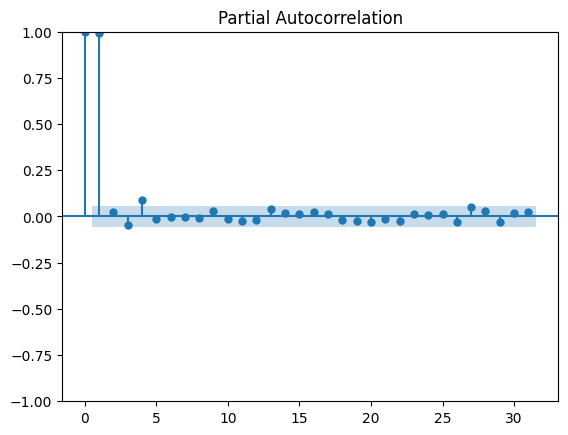

In [24]:
#autocorrelation and partial autocorelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_traning = plot_acf(apple["Log(Open)"])
pacf_training = plot_pacf(apple["Log(Open)"])

In [25]:
#ADF test
#null hypothesis
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train["Log(Open)"])
print(adf_test[1])

0.2972442014656511


The results of the test suggest that the data is non-stationery. It should be less than 0.05 or 0.01 to be considered as stationery.

# Data differencing

In [26]:
df_train["Diff_Log(Open)"] = df_train["Log(Open)"].diff().dropna()

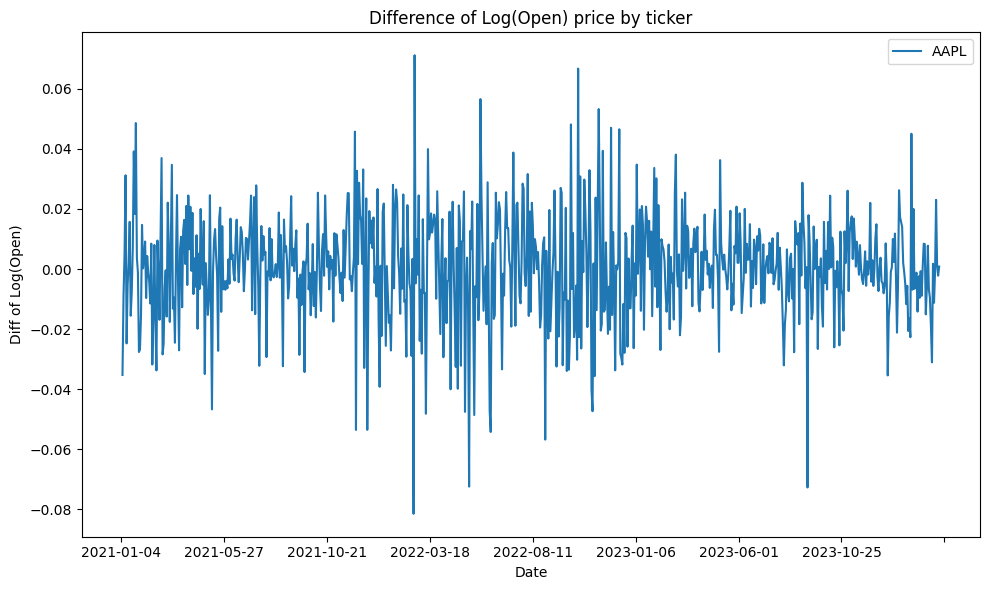

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

for ticker, grp in df_train.groupby('Ticker'):
    grp.plot(x='Date', y='Diff_Log(Open)', ax=ax, label=ticker,linewidth=1.5)

ax.set_title('Difference of Log(Open) price by ticker')
ax.set_xlabel('Date')
ax.set_ylabel('Diff of Log(Open)')
plt.tight_layout()
plt.show()

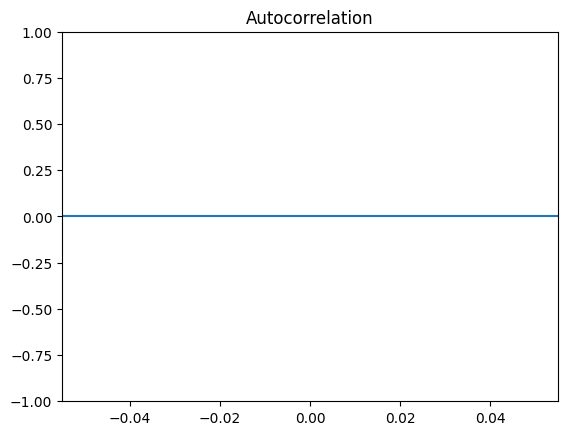

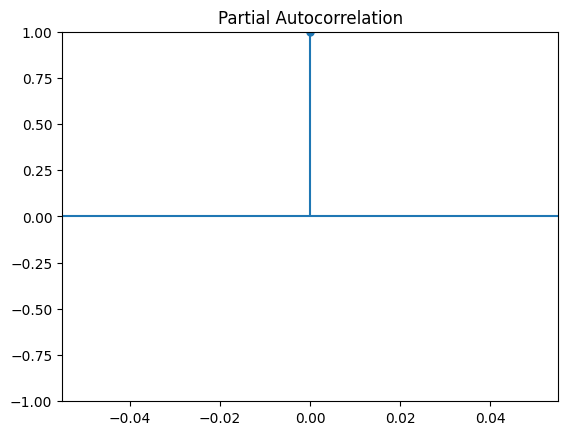

In [28]:
acf_traning_diff = plot_acf(df_train["Diff_Log(Open)"])
pacf_training_diff = plot_pacf(df_train["Diff_Log(Open)"])

Ok, the data is ready, likely to be stationary. Autocorrelation is 0, so there is no need for MA, therefore q = 1, d = 1 also because differenciation helped. Let's also put p = 1

# Fit the model

In [29]:
#for now, d = 1, p = 1, q = 0
#ARIMA(1,1,0)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train["Log(Open)"], order = (1,1,0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Log(Open)   No. Observations:                  796
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2080.614
Date:                Wed, 04 Jun 2025   AIC                          -4157.228
Time:                        19:07:02   BIC                          -4147.872
Sample:                             0   HQIC                         -4153.633
                                - 796                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0365      0.030     -1.236      0.217      -0.094       0.021
sigma2         0.0003   1.15e-05     27.223      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

<Axes: title={'center': 'Density'}, ylabel='Density'>

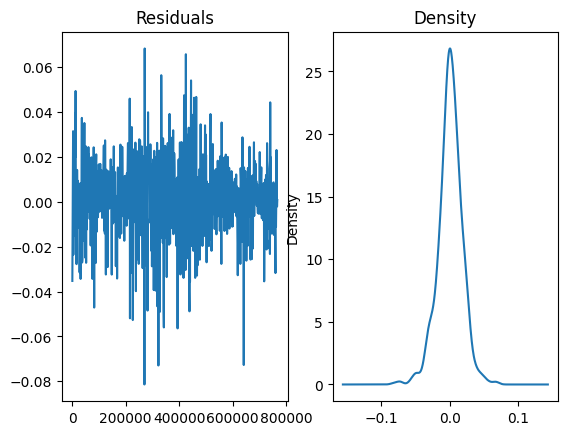

In [30]:
#before making time series predictions, check on residuals
import matplotlib.pyplot as plt
resids = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
resids.plot(title = 'Residuals', ax = ax[0])
resids.plot(title = 'Density', kind = 'kde', ax = ax[1])

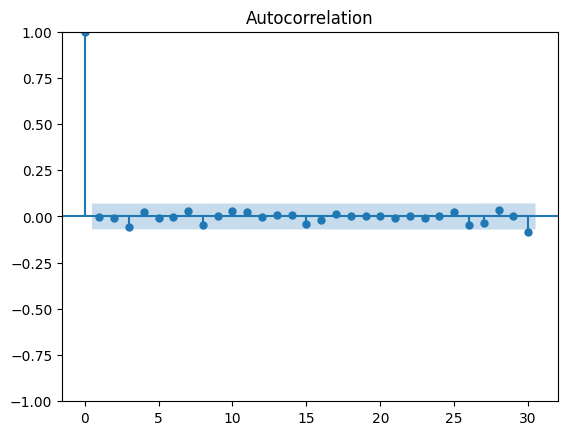

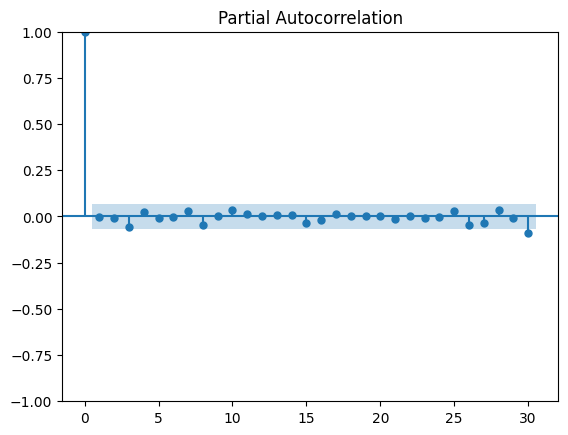

In [31]:
acf_resids = plot_acf(resids)
pacf_resids = plot_pacf(resids)

Let's stick with 1,1,0 for now.

# Forecast testing

In [32]:
forecast = model_fit.forecast(len(df_test["Log(Open)"]))
forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean
796,5.146720
797,5.146722
798,5.146721
799,5.146721
800,5.146721
...,...
1091,5.146721
1092,5.146721
1093,5.146721
1094,5.146721


In [33]:
concat_testni_forecast = pd.concat([df_test.reset_index(drop=True), forecast.reset_index(drop=True)], axis = 1).dropna()
concat_testni_forecast

,index,Ticker,Date,Close,High,Low,Open,Volume,Log(Open),predicted_mean
0,768070,AAPL,2024-03-15,171.583740,171.583740,169.267726,170.142448,121664700.0,5.136636,5.146720
1,769051,AAPL,2024-03-18,172.677139,176.643192,172.478343,174.516040,75604200.0,5.162017,5.146722
2,770032,AAPL,2024-03-19,175.022964,175.549782,171.991271,173.293405,55215200.0,5.154986,5.146721
3,771013,AAPL,2024-03-20,177.597412,177.597412,174.038902,174.665124,53423100.0,5.162871,5.146721
4,771995,AAPL,2024-03-21,170.341232,176.424503,169.814415,175.987142,106181300.0,5.170411,5.146721
...,...,...,...,...,...,...,...,...,...,...
295,1060277,AAPL,2025-05-22,201.360001,202.750000,199.699997,200.710007,46742400.0,5.301861,5.146721
296,1061273,AAPL,2025-05-23,195.270004,197.699997,193.460007,193.669998,78432900.0,5.266156,5.146721
297,1062269,AAPL,2025-05-27,200.210007,200.740005,197.429993,198.300003,56288500.0,5.289781,5.146721
298,1063265,AAPL,2025-05-28,200.419998,202.729996,199.899994,200.589996,45339700.0,5.301263,5.146721


Model bi trebalo da okej radi s obzirom da se na plotu reziduala vidjelo da je raspodjela normalna. Vidi se iz toga koliki je predicted mean u odnosu na Log(Open) koji su stvarna vrijednost. Ideja bi bila sada vidjeti kretanje, pa proracunavati dalje parametre iz ovoga. ARIMA bi trebala da super radi zbog toga što ne radi 1-step forecasting kao vecina drugih modela.